In [5]:
import numpy as np# https://stackoverflow.com/questions/11788950/importing-numpy-into-functions
import torch
from torch.nn import functional as F# https://twitter.com/francoisfleuret/status/1247576431762210816
from torch import nn
#device = torch.device('cpu')# device = torch.device('cuda')    

In [7]:
# Elman network
# h[t] = ReLU(  Whh @ h[t−1] + 􏰨Whx @ x[t] + bh􏰩  )
# y[t] = Wyh @ h[t] + by

# parameters to be learned: Whh, Whx, bh, Wyh, by, h0(optional)
class ElmanRNN(nn.Module):# class RecNet inherits from class torch.nn.Module
    def __init__(self, dim_input, dim_recurrent, dim_output, LEARN_h0 = False):
        super().__init__()# super allows you to call methods of the superclass in your subclass
        
        self.fc_x2h = nn.Linear(dim_input, dim_recurrent)# Whx @ x + bh
        self.fc_h2h = nn.Linear(dim_recurrent, dim_recurrent, bias = False)# Whh @ h
        self.fc_h2y = nn.Linear(dim_recurrent, dim_output)# y = Wyh @ h + by
        self.numparameters = dim_recurrent**2 + dim_recurrent*dim_input + dim_recurrent + dim_output*dim_recurrent + dim_output# number of learned parameters in model
        
        #------------------------------
        # initialize the biases bh and by to be 0
        self.fc_x2h.bias = torch.nn.Parameter(torch.zeros(dim_recurrent))# https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py#L48-L52
        self.fc_h2y.bias = torch.nn.Parameter(torch.zeros(dim_output))# https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py#L48-L52

        #------------------------------
        # set the initial state h0 to be 0
        if LEARN_h0:
            self.h0 = torch.nn.Parameter(torch.zeros(dim_recurrent), requires_grad=True)# learn initial value for h, https://discuss.pytorch.org/t/learn-initial-hidden-state-h0-for-rnn/10013/6  https://discuss.pytorch.org/t/solved-train-initial-hidden-state-of-rnns/2589/8
            self.numparameters = self.numparameters + dim_recurrent# number of learned parameters in model
        else:
            self.h0 = torch.nn.Parameter(torch.zeros(dim_recurrent), requires_grad=False)# (dim_recurrent,) tensor   
    
    # output y and h for all numT timesteps
    def forward(self, input):# input has size (numtrials, numT, dim_input)
        
        #numtrials, numT, dim_input = input.size()# METHOD 1
        numtrials, numT, dim_input = input.shape# METHOD 2
        
        #dim_recurrent = self.fc_h2y.weight.size(1)# y = Wyh @ h + by, METHOD 1
        #dim_recurrent = self.fc_h2y.weight.shape[1]# y = Wyh @ h + by, METHOD 2
        h = self.h0.repeat(numtrials, 1)# (numtrials, dim_recurrent) tensor, all trials should have the same initial value for h, not different values for each trial    
        
        hstore = []# (numtrials, numT, dim_recurrent)
        
        for t in range(numT):# t=0,1,2,...,numT-1
            h = F.relu(self.fc_x2h(input[:,t,:]) + self.fc_h2h(h))# input[:,t].size() is (numtrials, dim_input)
            hstore.append(h)# hstore += [h]
        
        hstore = torch.stack(hstore,dim=1)# (numtrials, numT, dim_recurrent), each appended h is stored in hstore[:,i,:], nn.Linear expects inputs of size (numtrials, *, dim_recurrent) where * means any number of additional dimensions  
        
        y = self.fc_h2y(hstore)# (numtrials, numT, dim_output) tensor, y = Wyh @ h + by
        
        return y, hstore
    
    # to get the output we could
    # 1) apply nn.Linear to h at each timestep (out = self.fc_h2y(h)) and then use output.append(out), followed by a final stack (output = torch.stack(output,dim=1)) to get the final output, or
    # 2) append and stack h across timesteps and then apply nn.Linear to hstore

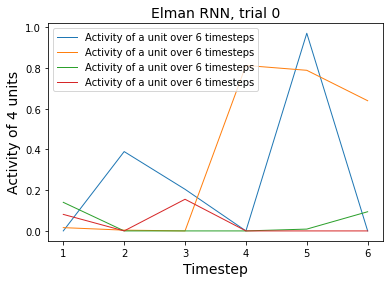

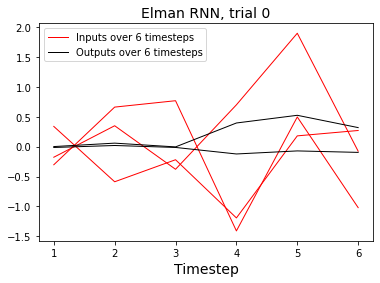

In [8]:
#%% test forward pass of Elman recurrent neural network
if __name__ == "__main__":
    #import os
    #dir = '/Users/christophercueva/Desktop/pytorch/cueva_RNN/template/'
    #os.chdir(dir)# print(f'current working direction is {os.getcwd()}')
    
    import matplotlib.pyplot as plt  
    from matplotlib import cm
    #from generateINandTARGETOUT import generateINandTARGETOUT# from file import function 
    torch.manual_seed(123)# set random seed for reproducible results
    
    dim_input = 3
    dim_recurrent = 4
    dim_output = 2
    numT = 6; T = np.arange(1,numT+1)# (numT,) array
    numtrials = 5
    
    #IN, TARGETOUT = generateINandTARGETOUT(dim_input=1, dim_output=1, numT=numT, numtrials=numtrials)
    IN = torch.randn(numtrials,numT,dim_input)
    model = ElmanRNN(dim_input, dim_recurrent, dim_output)
    output_pytorch, h_pytorch = model(IN)
    output = output_pytorch.detach().numpy()
    h = h_pytorch.detach().numpy()
    
    #---------------check number of learned parameters---------------
    numparameters = sum(p.numel() for p in model.parameters() if p.requires_grad)# model.parameters include those defined in __init__ even if they are not used in forward pass
    assert np.allclose(model.numparameters, numparameters), "Number of learned parameters don't match!"
    
    
    fig, ax = plt.subplots()# activity of RNN units over time
    fontsize = 14
    itrial = 0
    ax.plot(T, h[itrial,:,:], linewidth=1, label=f'Activity of a unit over {numT} timesteps')
    ax.legend()
    ax.set_xlabel('Timestep', fontsize=fontsize)
    ax.set_ylabel(f'Activity of {dim_recurrent} units', fontsize=fontsize)
    ax.set_title(f'Elman RNN, trial {itrial}', fontsize=fontsize)
    
    
    fig, ax = plt.subplots()# inputs and RNN outputs over time
    fontsize = 14
    itrial = 0
    handle1 = ax.plot(T, IN[itrial,:,:], 'r-', linewidth=1)# inputs
    handle2 = ax.plot(T, output[itrial,:,:], 'k-', linewidth=1)# outputs
    ax.legend(handles=[handle1[0],handle2[0]], labels=[f'Inputs over {numT} timesteps',f'Outputs over {numT} timesteps'], loc='best', frameon=True)
    ax.set_xlabel('Timestep', fontsize=fontsize)
    ax.set_title(f'Elman RNN, trial {itrial}', fontsize=fontsize)